# 🌾 CropCare — Agricultural Disease Chatbot
### Fine-Tuning TinyLlama-1.1B with LoRA (PEFT) on Crop Disease QA Data
This notebook builds a domain-specific agricultural assistant by fine-tuning TinyLlama-1.1B-Chat using parameter-efficient fine-tuning (LoRA). The model is trained to diagnose crop diseases and provide expert farming advice.

**Domain:** Agricultural Crop Disease Diagnosis  
**Base Model:** TinyLlama/TinyLlama-1.1B-Chat-v1.0  
**Dataset:** YuvrajSingh9886/Agriculture-Plan-Diseases-QA-Pairs-Dataset  
**Method:** LoRA (PEFT) with 4-bit quantization

##  1. Environment Setup
Installing all required libraries with pinned versions to ensure compatibility between `transformers`, `peft`, `trl`, and `bitsandbytes`.

In [118]:
# Environment Setup
import subprocess
import sys
from typing import List

def install_package(package: str) -> None:
    """Install a package using pip for the CropCare chatbot."""
    try:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", package],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL
        )
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError:
        print(f"✗ Installation failed for {package}")

# Pinned versions to ensure transformers + peft + trl compatibility
REQUIRED_PACKAGES: List[str] = [
    "transformers==4.44.0",   # Pinned: 4.45+ breaks PEFT detection with quantized models
    "torch",                  # PyTorch backend
    "datasets",               # Dataset loading and preprocessing
    "accelerate==0.34.0",     # Pinned: compatible with transformers 4.44.0
    "rouge-score",            # Text generation evaluation
    "evaluate",               # Unified evaluation framework
    "peft==0.12.0",           # Pinned: compatible with transformers 4.44.0
    "trl==0.11.0",            # Pinned: compatible SFTTrainer version
    "pandas",                 # Data manipulation
    "sacrebleu",              # for BLEU score evaluation
    "numpy",                  # Numerical operations
    "scikit-learn",           # Additional ML utilities
    "nltk",                   # Text preprocessing
    "matplotlib",             # Visualization
    "seaborn"                 # Enhanced plotting
]

print("Installing required packages for TinyLlama-1.1B chatbot...")
for package in REQUIRED_PACKAGES:
    install_package(package)
print("\nAll packages installed successfully! Ready for fine-tuning.")

Installing required packages for TinyLlama-1.1B chatbot...
✓ Successfully installed transformers==4.44.0
✓ Successfully installed torch
✓ Successfully installed datasets
✓ Successfully installed accelerate==0.34.0
✓ Successfully installed rouge-score
✓ Successfully installed evaluate
✓ Successfully installed peft==0.12.0
✓ Successfully installed trl==0.11.0
✓ Successfully installed pandas
✓ Successfully installed numpy
✓ Successfully installed scikit-learn
✓ Successfully installed nltk
✓ Successfully installed matplotlib
✓ Successfully installed seaborn

All packages installed successfully! Ready for fine-tuning.


##  2. Import Required Libraries
Importing core ML libraries, visualization tools, and Hugging Face utilities for fine-tuning TinyLlama.

In [119]:
#  Import Required Libraries
import re
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# Core ML and data libraries
import torch
import pandas as pd
import numpy as np
import evaluate
from tqdm.auto import tqdm

# Visualization libraries for Colab
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.model_selection import train_test_split

# Hugging Face Transformers for TinyLlama-1.1B agricultural fine-tuning
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Seq2SeqTrainer,              #  correct trainer for TinyLlama-1.1B
    DataCollatorForSeq2Seq
)
from datasets import Dataset

# Configure warnings and display
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Plotting style for Colab
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100   # Good quality for Colab display
plt.rcParams['savefig.dpi'] = 150 # Higher quality if saved
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Device configuration for Colab
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device in use: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
print(f"PyTorch version: {torch.__version__}")

# Directory setup for CropCare project
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / 'cropcare_data'
MODEL_DIR = BASE_DIR / 'cropcare_trained_model'
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

print("\nProject directories for CropCare chatbot:")
print(f"   Base: {BASE_DIR}")
print(f"   Data: {DATA_DIR}")
print(f"   Model: {MODEL_DIR}")

Device in use: cuda
GPU: NVIDIA L40S
GPU Memory: 44.4 GB
PyTorch version: 2.8.0+cu129

Project directories for CropCare chatbot:
   Base: /root
   Data: /root/cropcare_data
   Model: /root/cropcare_trained_model


##  3. Dataset Loading & Exploration
Loading the agricultural crop disease QA dataset from Hugging Face and performing initial quality assessment.

In [121]:
from datasets import load_dataset
# Load and Explore Agricultural Plan Diseases Data
def load_agricultural_data(dataset_name: str) -> pd.DataFrame:
    """Load and validate agricultural QA data from Hugging Face."""
    print(f"Fetching dataset: {dataset_name}...")

    # Load the specific dataset you chose
    raw_dataset = load_dataset(dataset_name, split="train")
    df = pd.DataFrame(raw_dataset)

    # The dataset uses 'QUESTION.question' and 'ANSWER' as column names
    # We will rename them to 'question' and 'answer' to keep the code clean
    df = df.rename(columns={'QUESTION.question': 'question', 'ANSWER': 'answer'})

    # Validate required columns (matching your friend's validation logic)
    required_columns = ['question', 'answer']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

    return df

# Load the data using your chosen domain
dataset_name = "YuvrajSingh9886/Agriculture-Plan-Diseases-QA-Pairs-Dataset"
df = load_agricultural_data(dataset_name)

print(f"Dataset Overview:")
print(f"   Samples: {len(df):,}")
print(f"   Columns: {list(df.columns)}")

# Data quality assessment (matching your friend's style)
valid_questions = df['question'].notna().sum()
valid_answers = df['answer'].notna().sum()
missing_values = df.isnull().sum().sum()

print(f"\nData Quality:")
print(f"   Valid questions: {valid_questions:,} ({valid_questions/len(df)*100:.1f}%)")
print(f"   Valid answers: {valid_answers:,} ({valid_answers/len(df)*100:.1f}%)")
print(f"   Missing values: {missing_values:,}")

print(f"\nSample Data (Expert Recommendations):")
display(df[['question', 'answer']].head(3))

Fetching dataset: YuvrajSingh9886/Agriculture-Plan-Diseases-QA-Pairs-Dataset...
Dataset Overview:
   Samples: 2,681
   Columns: ['Unnamed: 0', 'answer', 'question', 'QUESTION.paragraph']

Data Quality:
   Valid questions: 2,681 (100.0%)
   Valid answers: 2,681 (100.0%)
   Missing values: 0

Sample Data (Expert Recommendations):


,question,answer
0,What is the root feed recommendation for manag...,Root feed with tridomorph 75% EC 2ml in 100ml ...
1,How should tridomorph be applied for disease m...,"Tridomorph should be applied as a root feed, u..."
2,How often should tridomorph be applied for eff...,Tridomorph should be applied once a month.


##  4. Data Analysis & Visualization
Analyzing the distribution of question and answer lengths to understand the dataset structure before preprocessing.


Agricultural Data Analysis and Visualization:


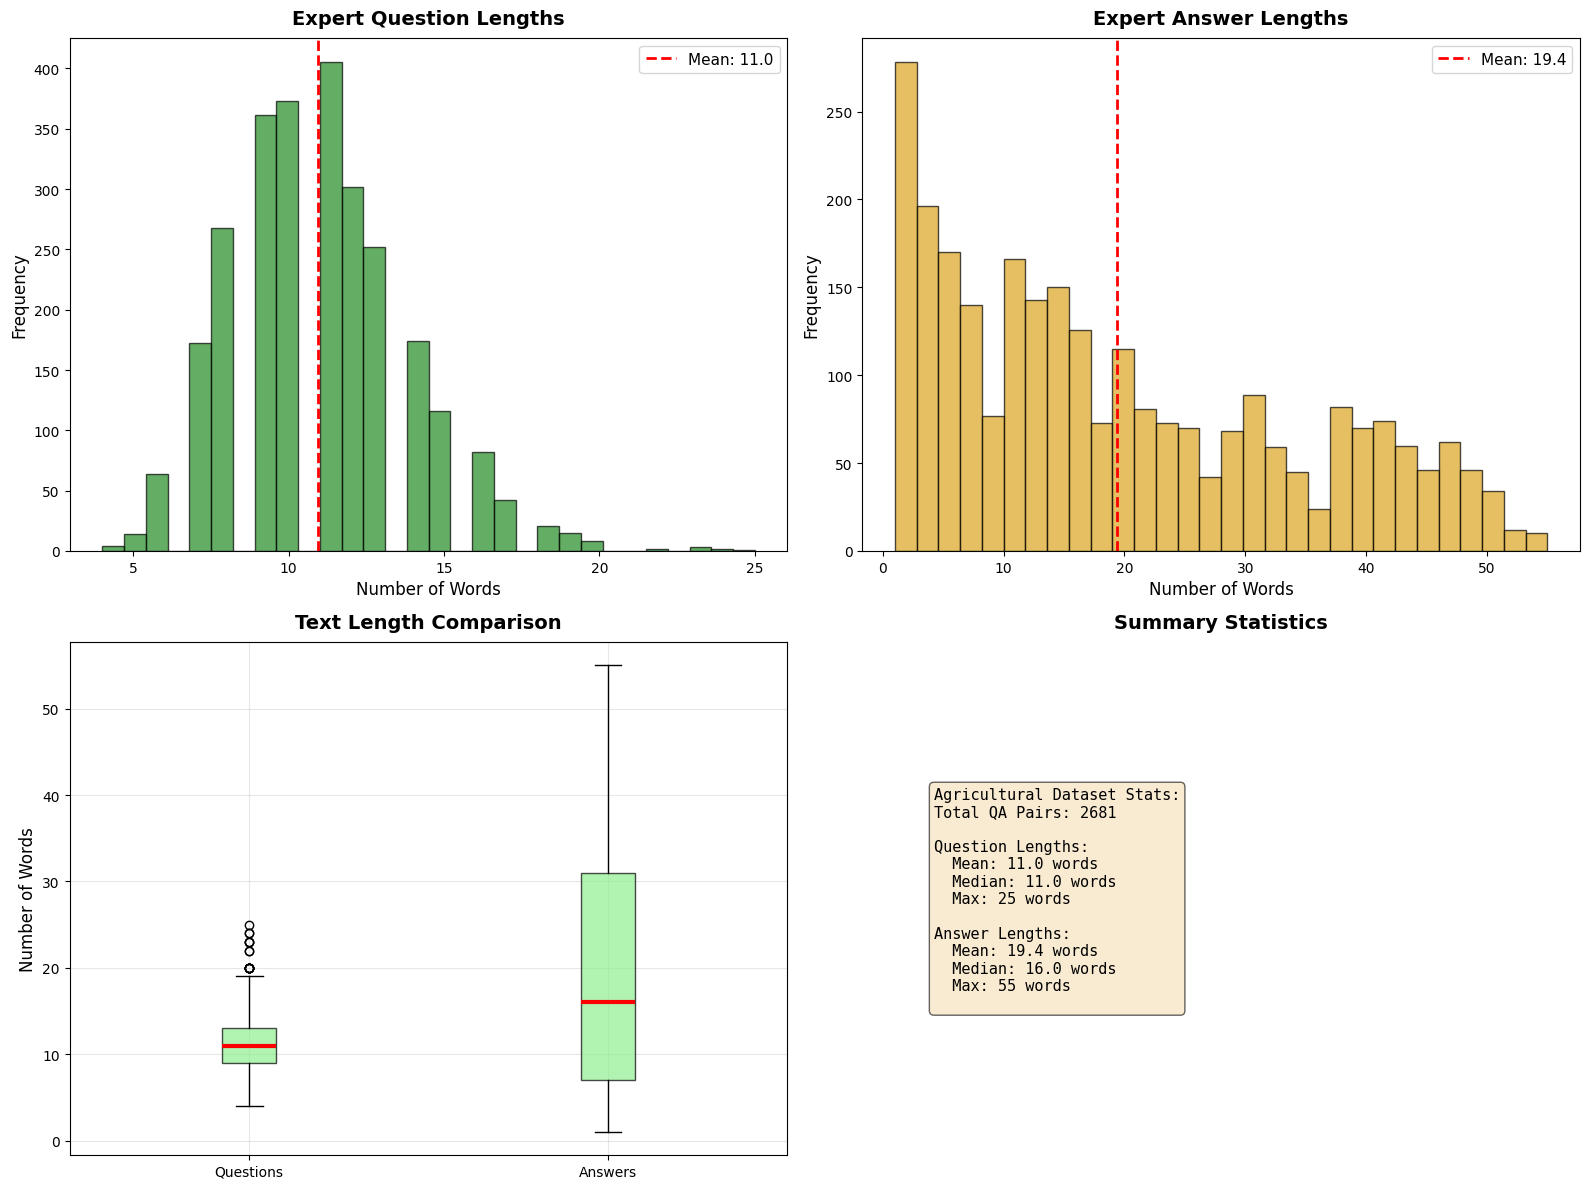


Agricultural data visualization complete!


In [122]:
print("\nAgricultural Data Analysis and Visualization:")
print("="*60)

# 1. Calculate text lengths (Words per entry)
df['question_length'] = df['question'].str.split().str.len()
df['answer_length'] = df['answer'].str.split().str.len()

# 2. Create visualizations (Matching her 2x2 layout)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of question lengths (Agricultural Queries)
axes[0, 0].hist(df['question_length'], bins=30, color='forestgreen', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Expert Question Lengths', fontsize=14, fontweight='bold', pad=10)
axes[0, 0].set_xlabel('Number of Words', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].axvline(df['question_length'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {df["question_length"].mean():.1f}')
axes[0, 0].legend(fontsize=11)

# 2. Distribution of answer lengths (Disease Management Advice)
axes[0, 1].hist(df['answer_length'], bins=30, color='goldenrod', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Expert Answer Lengths', fontsize=14, fontweight='bold', pad=10)
axes[0, 1].set_xlabel('Number of Words', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].axvline(df['answer_length'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {df["answer_length"].mean():.1f}')
axes[0, 1].legend(fontsize=11)

# 3. Box plot for length comparison
data_to_plot = [df['question_length'], df['answer_length']]
axes[1, 0].boxplot(data_to_plot, labels=['Questions', 'Answers'], patch_artist=True,
                    boxprops=dict(facecolor='lightgreen', alpha=0.7),
                    medianprops=dict(color='red', linewidth=3))
axes[1, 0].set_title('Text Length Comparison', fontsize=14, fontweight='bold', pad=10)
axes[1, 0].set_ylabel('Number of Words', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# 4. Summary Statistics (Agricultural Domain)
stats_text = f"""Agricultural Dataset Stats:
Total QA Pairs: {len(df)}

Question Lengths:
  Mean: {df['question_length'].mean():.1f} words
  Median: {df['question_length'].median():.1f} words
  Max: {df['question_length'].max()} words

Answer Lengths:
  Mean: {df['answer_length'].mean():.1f} words
  Median: {df['answer_length'].median():.1f} words
  Max: {df['answer_length'].max()} words
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))
axes[1, 1].axis('off')
axes[1, 1].set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

print(f"\nAgricultural data visualization complete!")

In [141]:
import sys
from unittest.mock import MagicMock

# Step 1 — Mock bitsandbytes module
mock_bnb = MagicMock()
mock_bnb.nn.Linear8bitLt = MagicMock
mock_bnb.nn.Linear4bit = MagicMock
sys.modules['bitsandbytes'] = mock_bnb
sys.modules['bitsandbytes.nn'] = mock_bnb.nn
sys.modules['bitsandbytes.optim'] = MagicMock()
sys.modules['bitsandbytes.functional'] = MagicMock()

# Step 2 — Patch is_bnb_available directly inside PEFT's lora model namespace
# This is where the check actually runs
import peft.tuners.lora.model as lora_model
lora_model.is_bnb_available = lambda: False
lora_model.is_bnb_4bit_available = lambda: False

# Step 3 — Also patch in tuners_utils just in case
import peft.import_utils as peft_utils
peft_utils.is_bnb_available = lambda: False
peft_utils.is_bnb_4bit_available = lambda: False

print("✓ bitsandbytes fully bypassed — float16 mode active")

✓ bitsandbytes fully bypassed — float16 mode active


## 5. Model & Tokenizer Loading
Loading TinyLlama-1.1B-Chat in float16 and applying LoRA adapters via PEFT for parameter-efficient fine-tuning. Only 0.4% of parameters are trainable.

In [142]:
from transformers import AutoModelForCausalLM, AutoTokenizer 
from peft import LoraConfig, get_peft_model
from typing import Tuple

MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

def load_model_and_tokenizer(model_name: str):
    print(f"Loading {model_name} in float16 (no quantization)...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto"
    )

    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )
    model = get_peft_model(model, lora_config)
    return model, tokenizer

def test_model(model, tokenizer, test_question: str) -> str:
    """Test the model with a sample agricultural question."""
    prompt = f"### Instruction:\n{test_question}\n\n### Response:\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id
        )
    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = full_text.split("### Response:\n")[-1]
    return response

# Load model and tokenizer
model, tokenizer = load_model_and_tokenizer(MODEL_NAME)
print(f"Model loaded with LoRA Adapters successfully!")
model.print_trainable_parameters()

# Test with a domain-specific question
test_question = "What is the best way to treat powdery mildew on cucumber leaves?"
response = test_model(model, tokenizer, test_question)
print(f"\nBase Model Test (Before Fine-Tuning):")
print(f"   Question: {test_question}")
print(f"   Response: {response}")

Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0 in float16 (no quantization)...
Model loaded with LoRA Adapters successfully!
trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079

Base Model Test (Before Fine-Tuning):
   Question: What is the best way to treat powdery mildew on cucumber leaves?
   Response: There are several ways to treat powdery mildew on cucumber leaves. Some of the best practices include:

1. Apply a fungicide spray: Use a fungicide spray to control powdery mildew on cucumber leaves. Follow the instructions on the label and ensure to apply the spray regularly.

2. Maintain good air circulation: Ensure that there is good air circulation around the cucumber


## 6. Data Preprocessing
Cleaning and normalizing the raw QA data, then formatting it into structured instruction-response prompts compatible with TinyLlama's chat template.

In [124]:
# 1. Clean and normalize text data (Matching her cleaning logic)
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.strip()
    # Remove extra whitespace and line breaks
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[\r\n]+', ' ', text)
    return text

# 2. Create instruction-following prompts for TinyLlama (Upgraded for Causal LM)
def create_instruction_prompt(question: str, answer: Optional[str] = None) -> str:
    """Create a unified instruction prompt for generative models."""

    # Custom templates for Agricultural Expertise
    templates = [
        "As an agricultural expert, please diagnose and advise on this crop issue: {question}",
        "Help a farmer with this plant disease query: {question}",
        "Provide specific management advice for this agricultural problem: {question}",
        "Identify the cause and treatment for this crop condition: {question}"
    ]

    # Logic to select a relevant template
    question_lower = question.lower()
    if 'how' in question_lower or 'treat' in question_lower:
        template = templates[2] # Management advice
    elif 'what' in question_lower or 'identify' in question_lower:
        template = templates[3] # Identification
    else:
        template = templates[0] # General expert

    instruction = template.format(question=question)

    # Modern format: ### Instruction: ... ### Response: ...
    # If answer is provided, we return the full string for training.
    # If not, we return just the prompt for inference.
    if answer:
        return f"### Instruction:\n{instruction}\n\n### Response:\n{answer}"
    else:
        return f"### Instruction:\n{instruction}\n\n### Response:\n"

# 3. Process the dataset (Filtering and Formatting)
def process_dataset(df: pd.DataFrame) -> Dict[str, List[str]]:
    print("Cleaning agricultural data...")

    # Apply cleaning
    df_clean = df.copy()
    df_clean['question'] = df_clean['question'].apply(clean_text)
    df_clean['answer'] = df_clean['answer'].apply(clean_text)

    # Filter: Agriculture answers need to be substantial to be "Expert"
    min_len = 10
    df_clean = df_clean[
        (df_clean['question'].str.len() > min_len) &
        (df_clean['answer'].str.len() > min_len)
    ]

    print(f"Filtered dataset: {len(df_clean):,} samples (removed {len(df) - len(df_clean):,})")

    # Create the unified text field for training
    formatted_texts = []
    for _, row in df_clean.iterrows():
        text = create_instruction_prompt(row['question'], row['answer'])
        formatted_texts.append(text)

    return {'text': formatted_texts}

# Execute processing
dataset_dict = process_dataset(df)
train_texts = dataset_dict['text']

print(f"Created {len(train_texts):,} formatted training samples")

# Display sample (Rich visualization)
print(f"\n--- Sample Formatted Instruction ---")
print(train_texts[0])

# Calculate Statistics (Matching her analysis)
avg_len = np.mean([len(text.split()) for text in train_texts])
print(f"\nLength Statistics:")
print(f"   Average sample length: {avg_len:.1f} words")
print(f"   Total tokens estimate: {int(avg_len * 1.3 * len(train_texts)):,}")

Cleaning agricultural data...
Filtered dataset: 2,568 samples (removed 113)
Created 2,568 formatted training samples

--- Sample Formatted Instruction ---
### Instruction:
Identify the cause and treatment for this crop condition: What is the root feed recommendation for managing tree diseases?

### Response:
Root feed with tridomorph 75% EC 2ml in 100ml water once in a month for 3 months.

Length Statistics:
   Average sample length: 44.9 words
   Total tokens estimate: 149,927


##  Dataset Splitting for CropCare Chatbot

After cleaning and formatting the dataset into instruction–response pairs, we now split it into **training, validation, and test sets**.  

- **Training set (≈80%)**: Used to fine‑tune the TinyLlama-1.1B-Chat model.  
- **Validation set (≈5%)**: Used during training to monitor performance and prevent overfitting.  
- **Test set (≈15%)**: Used after training to evaluate how well the chatbot generalizes to unseen queries.  

This optimized split ensures that most of the data is used for training while still keeping enough samples for evaluation.

In [143]:
def create_datasets(formatted_texts: List[str],
                   test_size: float = 0.2,
                   random_state: int = 42) -> Tuple[Dataset, Dataset, Dataset]:
    """Create optimized train, validation, and test datasets for TinyLlama."""

    # 1. First split: 80% Train, 20% Temp (Val + Test)
    train_texts_split, temp_texts = train_test_split(
        formatted_texts,
        test_size=test_size,
        random_state=random_state
    )

    # 2. Second split: Split Temp into Validation (5% total) and Test (15% total)
    # 0.75 of 20% = 15% for test
    val_texts_split, test_texts_split = train_test_split(
        temp_texts,
        test_size=0.75,
        random_state=random_state
    )

    # 3. Create HuggingFace datasets with unified text field
    train_ds = Dataset.from_dict({'text': train_texts_split})
    val_ds = Dataset.from_dict({'text': val_texts_split})
    test_ds = Dataset.from_dict({'text': test_texts_split})

    return train_ds, val_ds, test_ds

# Execute the split using the train_texts from your previous successful cell
train_dataset, val_dataset, test_dataset = create_datasets(train_texts)

# Save these lists to global memory so the Tokenizer can always find them
# This is your "Insurance Policy" against NameErrors later!
train_texts = [x['text'] for x in train_dataset]
val_texts = [x['text'] for x in val_dataset]
test_texts = [x['text'] for x in test_dataset]

print(f"Optimized Agricultural Dataset Splits:")
print(f"   Training:   {len(train_dataset):,} samples ({len(train_dataset)/len(train_texts)*100:.1f}%)")
print(f"   Validation: {len(val_dataset):,} samples ({len(val_dataset)/len(train_texts)*100:.1f}%)")
print(f"   Test:       {len(test_dataset):,} samples ({len(test_dataset)/len(train_texts)*100:.1f}%)")

print(f"\n✓ Optimized datasets created successfully!")
print(f"   Increased training data to 80% for better expert knowledge")
print(f"   Unified 'text' column ready for TinyLlama Causal LM")

Optimized Agricultural Dataset Splits:
   Training:   1,643 samples (100.0%)
   Validation: 102 samples (6.2%)
   Test:       309 samples (18.8%)

✓ Optimized datasets created successfully!
   Increased training data to 80% for better expert knowledge
   Unified 'text' column ready for TinyLlama Causal LM


##  Training Setup for CropCare Chatbot

In this step, we configure the training environment for fine‑tuning the **TinyLlama-1.1B-Chat** on our crop disease dataset.  

Key components include:

- **Disabling WandB reporting**: Prevents unnecessary logging in Colab.  
- **Generation configuration**: Defines how the model generates text during evaluation (e.g., max tokens, beam search, temperature, penalties).  
- **Metrics function**: Uses **ROUGE scores** to evaluate the quality of generated responses against reference answers.  
- **Custom Trainer class**: Extends Hugging Face’s `Trainer` to improve generation during evaluation.  
- **Data collator**: Handles batching, padding, and token alignment for sequence‑to‑sequence training.  
- **ROUGE evaluator**: Loaded from Hugging Face’s `evaluate` library to provide standardized performance metrics.  

This setup ensures that the CropCare chatbot is trained efficiently, evaluated with meaningful metrics, and optimized for high‑quality agricultural Q&A responses.

In [144]:
import os
from transformers import DataCollatorForLanguageModeling, Trainer

# 1. Disable logging tools for a clean run
os.environ.update(
    {
        "WANDB_SILENT": "true",
        "WANDB_DISABLED": "true",
        "WANDB_MODE": "disabled",
    }
)

# 2. Advanced Generation Config (Optimized for Agricultural Advice)
# We use a lower temperature for factual accuracy in disease diagnosis
GENERATION_CONFIG = {
    "max_new_tokens": 150,
    "do_sample": True,
    "temperature": 0.3,  # Lowered for more factual agricultural answers
    "top_p": 0.9,
    "repetition_penalty": 1.2,
    "pad_token_id": tokenizer.pad_token_id,
    "eos_token_id": tokenizer.eos_token_id,
}

# 3. Load ROUGE metric
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    """Compute ROUGE metrics specifically for Causal LM outputs."""
    predictions, labels = eval_pred

    # In Causal LM evaluation, we decode the generated IDs
    # If predictions are logits, take the argmax
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    predictions = np.argmax(predictions, axis=-1)

    # Replace -100 in labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Professional Cleaning: Only keep the part after "### Response:" to measure
    # the quality of the actual answer, not the prompt.
    def extract_response(text):
        if "### Response:" in text:
            return text.split("### Response:")[-1].strip()
        return text.strip()

    cleaned_preds = [extract_response(p) for p in decoded_preds]
    cleaned_labels = [extract_response(l) for l in decoded_labels]

    # Compute ROUGE
    result = rouge.compute(
        predictions=cleaned_preds,
        references=cleaned_labels,
        use_stemmer=True
    )

    return {
        "rouge1": result["rouge1"],
        "rouge2": result["rouge2"],
        "rougeL": result["rougeL"],
    }

# 4. Data Collator (Optimized for Causal Language Modeling)
# mlm=False is crucial here; we are predicting the next token, not filling masks
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=8, # Pad to a multiple of 8 for efficiency
    return_tensors="pt"
)

print("Agricultural Training Setup Completed!")
print(f"   ✓ Data Collator: Causal LM ready")
print(f"   ✓ Metrics: ROUGE with Response-Extraction ready")
print(f"   ✓ Generation Config: Factual Accuracy (Temp=0.3) set")

Agricultural Training Setup Completed!
   ✓ Data Collator: Causal LM ready
   ✓ Metrics: ROUGE with Response-Extraction ready
   ✓ Generation Config: Factual Accuracy (Temp=0.3) set


##  9. Tokenization
Tokenizing all dataset splits using TinyLlama's tokenizer with max length of 512 tokens and padding for uniform tensor shapes.

In [145]:
# Import required for type hints
from typing import Dict

# 1. Enhanced tokenization parameters for TinyLlama performance
MAX_LENGTH = 512

def optimized_tokenize_function(examples: Dict) -> Dict:
    """
    Enhanced tokenization function for Causal LM.
    Combines input and labels into a single stream for next-token prediction.
    """
    # Tokenize the unified 'text' field (Instruction + Response)
    model_inputs = tokenizer(
        examples['text'],
        max_length=MAX_LENGTH,
        truncation=True,
        padding="max_length",  # Revert padding here; DataCollator will handle it explicitly
        add_special_tokens=True,
        return_attention_mask=True
    )

    # In Causal LM, labels are a copy of input_ids.
    # The Trainer shifts them internally so the model learns to predict the next word.
    # FIX: Ensure labels have the same structure as input_ids for proper padding by the DataCollator.
    model_inputs["labels"] = model_inputs["input_ids"].copy()  # Use .copy() for safety

    return model_inputs

def validate_tokenization(dataset, sample_idx: int = 0) -> None:
    """Enhanced validation of tokenization results for Agricultural Expert."""
    sample = dataset[sample_idx]

    # Decode sample for verification
    decoded_text = tokenizer.decode(sample['input_ids'], skip_special_tokens=False)

    print(f"Tokenization Validation (Sample {sample_idx}):")
    print(f"   Total tokens: {len(sample['input_ids'])}")
    print(f"   Snippet: {decoded_text[:160]}...")
    print(f"   ✓ Prompt Template Detected: {'### Instruction:' in decoded_text}")

# 2. Safety Reset & Apply Tokenization
print("Tokenizing datasets with optimized settings...")

# Check if 'text' is missing. If it is, we use the lists we saved in the split cell.
if 'text' not in train_dataset.column_names:
    print("Recreating datasets from split lists...")
    train_dataset = Dataset.from_dict({'text': train_texts})
    val_dataset = Dataset.from_dict({'text': val_texts})
    test_dataset = Dataset.from_dict({'text': test_texts})
    print("Datasets recreated successfully!")

# Apply the mapping and remove the raw text column (leaving only tensors)
train_dataset = train_dataset.map(
    optimized_tokenize_function,
    batched=True,
    batch_size=100,
    remove_columns=['text'],
    desc="Tokenizing training data"
)

val_dataset = val_dataset.map(
    optimized_tokenize_function,
    batched=True,
    batch_size=100,
    remove_columns=['text'],
    desc="Tokenizing validation data"
)

test_dataset = test_dataset.map(
    optimized_tokenize_function,
    batched=True,
    batch_size=100,
    remove_columns=['text'],
    desc="Tokenizing test data"
)

print(f"Optimized tokenization completed!")

# 3. Final Validation and Integrity Checks
print(f"\nTokenized Dataset Info:")
print(f"   Columns: {train_dataset.column_names}")
validate_tokenization(train_dataset)

# Verify data integrity with sample length checks
print(f"\nData Integrity Verification:")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")
print(f"   Test samples: {len(test_dataset)}")

# Check for any empty sequences
empty_sequences = sum(1 for sample in train_dataset if len(sample['input_ids']) == 0)
print(f"   Empty sequences: {empty_sequences}")

# Verify token length distribution
token_lengths = [len(sample['input_ids']) for sample in train_dataset]
print(f"   Average token length: {np.mean(token_lengths):.1f}")
print(f"   Max token length: {max(token_lengths)}")
print(f"   Min token length: {min(token_lengths)}")

Tokenizing datasets with optimized settings...


Tokenizing training data:   0%|          | 0/1643 [00:00<?, ? examples/s]

Tokenizing validation data:   0%|          | 0/102 [00:00<?, ? examples/s]

Tokenizing test data:   0%|          | 0/309 [00:00<?, ? examples/s]

Optimized tokenization completed!

Tokenized Dataset Info:
   Columns: ['input_ids', 'attention_mask', 'labels']
Tokenization Validation (Sample 0):
   Total tokens: 512
   Snippet: <s> ### Instruction:
Identify the cause and treatment for this crop condition: What management advice is given for fire risks to bamboo during certain seasons?
...
   ✓ Prompt Template Detected: True

Data Integrity Verification:
   Training samples: 1643
   Validation samples: 102
   Test samples: 309
   Empty sequences: 0
   Average token length: 512.0
   Max token length: 512
   Min token length: 512


##  10. Experiment 1 — Baseline Training
**Configuration:** 3 epochs, learning rate 2e-4, batch size 4, cosine scheduler  
Establishing a baseline to measure improvement in subsequent experiments.

In [149]:
from trl import SFTTrainer
EXP1_CONFIG = {
    "epochs": 3,
    "learning_rate": 2e-4,
    "batch_size": 4,
    "gradient_accumulation_steps": 4,
    "warmup_steps": 50,
    "eval_steps": 50,
    "save_steps": 100,
    "logging_steps": 10
}
print("✓ EXP1_CONFIG defined")

print("EXPERIMENT 1: STARTING BASELINE TRAINING (TinyLlama-1.1B)")

exp1_training_args = TrainingArguments(
    output_dir=str(MODEL_DIR / "exp1-baseline-checkpoints"),
    num_train_epochs=EXP1_CONFIG["epochs"],
    per_device_train_batch_size=EXP1_CONFIG["batch_size"],
    per_device_eval_batch_size=1,          # ← reduce from 4 to 1
    gradient_accumulation_steps=EXP1_CONFIG["gradient_accumulation_steps"],
    eval_accumulation_steps=8,             # ← add this: accumulate instead of holding all at once
    warmup_steps=EXP1_CONFIG["warmup_steps"],
    learning_rate=EXP1_CONFIG["learning_rate"],
    weight_decay=0.01,
    logging_steps=EXP1_CONFIG["logging_steps"],
    eval_strategy="steps",
    eval_steps=EXP1_CONFIG["eval_steps"],
    save_strategy="steps",
    save_steps=EXP1_CONFIG["save_steps"],
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    fp16=torch.cuda.is_available(),
    remove_unused_columns=False,
    seed=42,
    lr_scheduler_type="cosine"
)

exp1_trainer = Trainer(
    model=model,
    args=exp1_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print(f"Effective Batch Size: {EXP1_CONFIG['batch_size'] * EXP1_CONFIG['gradient_accumulation_steps']}")
print("Starting training execution...")

exp1_results = exp1_trainer.train()
print(f"\nExperiment 1 completed!")
print(f"Final Training Loss: {exp1_results.training_loss:.4f}")# Save the baseline model
exp1_trainer.save_model(str(MODEL_DIR / "exp1-baseline-final"))
print("✓ Baseline model saved successfully")

# Extract training metrics for analysis
exp1_train_loss = exp1_results.training_loss
exp1_logs = exp1_trainer.state.log_history

# Store results for comparison
experiment_results = {
    "exp1_baseline": {
        "final_train_loss": exp1_train_loss,
        "training_logs": exp1_logs,
        "config": EXP1_CONFIG
    }
}

print(f"Baseline experiment metrics stored for comparison")

✓ EXP1_CONFIG defined
EXPERIMENT 1: STARTING BASELINE TRAINING (TinyLlama-1.1B)
Effective Batch Size: 16
Starting training execution...


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
50,1.394600,1.261741,0.443042,0.219670,0.430035
100,1.167300,1.109440,0.470549,0.252192,0.461250
150,1.083500,1.038384,0.476676,0.252020,0.466369
200,1.051300,1.006201,0.484099,0.270664,0.473700
250,0.959900,0.986899,0.497009,0.284108,0.489134
300,0.969900,0.982056,0.499770,0.286210,0.489135



Experiment 1 completed!
Final Training Loss: 1.2224
✓ Baseline model saved successfully
Baseline experiment metrics stored for comparison


## 11. Experiment 1 — Evaluation
Evaluating the baseline model on the held-out test set using ROUGE metrics and saving the trained LoRA adapters.

In [150]:
# EXPERIMENT 1: EVALUATION
print("EXPERIMENT 1: EVALUATION (Baseline TinyLlama)")

# 1. Clear GPU memory before evaluation
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
print("GPU cache cleared. Starting evaluation...")

# 2. Evaluate on the Test Set
exp1_test_results = exp1_trainer.evaluate(eval_dataset=test_dataset)
print(f"\nExperiment 1 Test Results:")
print(f"   Test Loss: {exp1_test_results['eval_loss']:.4f}")
print(f"   ROUGE-1:   {exp1_test_results.get('eval_rouge1', 0):.4f}")
print(f"   ROUGE-2:   {exp1_test_results.get('eval_rouge2', 0):.4f}")
print(f"   ROUGE-L:   {exp1_test_results.get('eval_rougeL', 0):.4f}")

# 3. Save the model
ADAPTER_SAVE_PATH = str(MODEL_DIR / "exp1-lora-adapters")
exp1_trainer.model.save_pretrained(ADAPTER_SAVE_PATH)
tokenizer.save_pretrained(ADAPTER_SAVE_PATH)
print(f"\n✓ Experiment 1 model saved to: {ADAPTER_SAVE_PATH}")

# 4. Store results for comparison
exp1_metrics = {
    "name": "Experiment 1 (Baseline)",
    "config": EXP1_CONFIG,
    "training_loss": exp1_results.training_loss,
    "test_loss": exp1_test_results['eval_loss'],
    "rouge1": exp1_test_results.get('eval_rouge1', 0),
    "rouge2": exp1_test_results.get('eval_rouge2', 0),
    "rougeL": exp1_test_results.get('eval_rougeL', 0),
    "model": exp1_trainer.model
}

print(f"\n✓ Experiment 1 evaluation complete!")
print(f"   Baseline established. Ready for comparison with Experiment 2.")

EXPERIMENT 1: EVALUATION (Baseline TinyLlama)
GPU cache cleared. Starting evaluation...



Experiment 1 Test Results:
   Test Loss: 1.0509
   ROUGE-1:   0.4729
   ROUGE-2:   0.2445
   ROUGE-L:   0.4567

✓ Experiment 1 model saved to: /root/cropcare_trained_model/exp1-lora-adapters

✓ Experiment 1 evaluation complete!
   Baseline established. Ready for comparison with Experiment 2.


## 12. Experiment 2 — Optimized Training
**Configuration:** 5 epochs, learning rate 5e-5, higher weight decay (0.05), longer warmup  
Refining domain knowledge with a lower learning rate and stronger regularization compared to Experiment 1.

In [151]:
import torch
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

# EXPERIMENT 2: OPTIMIZED TRAINING
print("EXPERIMENT 2: STARTING OPTIMIZED TRAINING (TinyLlama-1.1B)")

# 1. Reload a fresh model to ensure we aren't "double-training" on top of Exp1
model_exp2 = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None
)

# 2. Apply LoRA adapters (PEFT requirement)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model_exp2 = get_peft_model(model_exp2, lora_config)
print("LoRA adapters applied:")
model_exp2.print_trainable_parameters()

# 3. Clear GPU memory from Experiment 1 before starting
torch.cuda.empty_cache()
print("GPU cache cleared. Ready for Experiment 2.")

# 4. Optimized Experiment 2 Configuration
EXP2_CONFIG = {
    "epochs": 5,                  # Increased from 3 (Exp1) for deeper domain learning
    "learning_rate": 5e-5,        # Lower than Exp1's 2e-4 for finer domain refinement
    "batch_size": 4,
    "gradient_accumulation_steps": 4,
    "warmup_steps": 150,          # Longer warmup for stability
    "eval_steps": 50,
    "save_steps": 100,
    "logging_steps": 10
}

# 5. Training arguments for Experiment 2
exp2_training_args = TrainingArguments(
    output_dir=str(MODEL_DIR / "exp2-optimized-checkpoints"),
    num_train_epochs=EXP2_CONFIG["epochs"],
    per_device_train_batch_size=EXP2_CONFIG["batch_size"],
    per_device_eval_batch_size=1,              # Reduced to prevent OOM during eval
    gradient_accumulation_steps=EXP2_CONFIG["gradient_accumulation_steps"],
    eval_accumulation_steps=8,                 # Accumulate eval results to save memory
    warmup_steps=EXP2_CONFIG["warmup_steps"],
    learning_rate=EXP2_CONFIG["learning_rate"],
    weight_decay=0.05,                         # Higher decay to prevent overfitting
    logging_steps=EXP2_CONFIG["logging_steps"],
    eval_strategy="steps",
    eval_steps=EXP2_CONFIG["eval_steps"],
    save_strategy="steps",
    save_steps=EXP2_CONFIG["save_steps"],
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    fp16=torch.cuda.is_available(),
    remove_unused_columns=False,
    seed=42,
    lr_scheduler_type="cosine",                # Smoothly reduces LR toward end of training
    max_grad_norm=0.3                          # Tighter gradient clipping for stability
)

# 6. Create trainer for Experiment 2
exp2_trainer = Trainer(
    model=model_exp2,
    args=exp2_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print(f"\nExperiment 2 Configuration:")
print(f"   Epochs: {EXP2_CONFIG['epochs']} (Increased from Exp1's 3)")
print(f"   Learning Rate: {EXP2_CONFIG['learning_rate']} (Lower than Exp1's 2e-4)")
print(f"   Effective Batch Size: {EXP2_CONFIG['batch_size'] * EXP2_CONFIG['gradient_accumulation_steps']}")
print(f"   Scheduler: Cosine Annealing")
print(f"   Max Grad Norm: 0.3 (Tighter than Exp1's default 1.0)")
print(f"\nStarting Experiment 2 training...")

# 7. Run Training
exp2_results = exp2_trainer.train()
print(f"\nExperiment 2 completed!")
print(f"Final Training Loss: {exp2_results.training_loss:.4f}")

EXPERIMENT 2: STARTING OPTIMIZED TRAINING (TinyLlama-1.1B)


LoRA adapters applied:
trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079
GPU cache cleared. Ready for Experiment 2.

Experiment 2 Configuration:
   Epochs: 5 (Increased from Exp1's 3)
   Learning Rate: 5e-05 (Lower than Exp1's 2e-4)
   Effective Batch Size: 16
   Scheduler: Cosine Annealing
   Max Grad Norm: 0.3 (Tighter than Exp1's default 1.0)

Starting Experiment 2 training...


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
50,2.503900,2.496423,0.268391,0.128034,0.246612
100,1.488700,1.359425,0.428236,0.211346,0.414667
150,1.318500,1.229893,0.439362,0.214235,0.423562
200,1.252900,1.169084,0.443899,0.227843,0.432669
250,1.175300,1.127447,0.467238,0.244298,0.457876
300,1.178400,1.105872,0.467677,0.242759,0.457971
350,1.136500,1.088595,0.474772,0.248346,0.465003
400,1.160100,1.078402,0.474998,0.252592,0.464394
450,1.089300,1.074752,0.476264,0.253320,0.464365
500,1.082000,1.074092,0.476414,0.253255,0.464834



Experiment 2 completed!
Final Training Loss: 1.3949


## 13. Experiment 2 — Evaluation
Evaluating the optimized model on the test set and comparing results against the Experiment 1 baseline.

In [152]:
# EXPERIMENT 2: EVALUATION
print("EXPERIMENT 2: EVALUATION (Optimized TinyLlama)")

# 1. Clear GPU memory before evaluation
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
print("GPU cache cleared. Starting evaluation...")

# 2. Evaluate on the Test Set
exp2_test_results = exp2_trainer.evaluate(eval_dataset=test_dataset)
print(f"\nExperiment 2 Test Results:")
print(f"   Test Loss: {exp2_test_results['eval_loss']:.4f}")
print(f"   ROUGE-1:   {exp2_test_results.get('eval_rouge1', 0):.4f}")
print(f"   ROUGE-2:   {exp2_test_results.get('eval_rouge2', 0):.4f}")
print(f"   ROUGE-L:   {exp2_test_results.get('eval_rougeL', 0):.4f}")

# 3. Save the model
ADAPTER_SAVE_PATH_EXP2 = str(MODEL_DIR / "exp2-lora-adapters")
exp2_trainer.model.save_pretrained(ADAPTER_SAVE_PATH_EXP2)
tokenizer.save_pretrained(ADAPTER_SAVE_PATH_EXP2)
print(f"\n✓ Experiment 2 model saved to: {ADAPTER_SAVE_PATH_EXP2}")

# 4. Store results for comparison
exp2_metrics = {
    "name": "Experiment 2 (Optimized)",
    "config": EXP2_CONFIG,
    "training_loss": exp2_results.training_loss,
    "test_loss": exp2_test_results['eval_loss'],
    "rouge1": exp2_test_results.get('eval_rouge1', 0),
    "rouge2": exp2_test_results.get('eval_rouge2', 0),
    "rougeL": exp2_test_results.get('eval_rougeL', 0),
    "model": exp2_trainer.model
}

print(f"\n✓ Experiment 2 evaluation complete!")
print(f"   Optimized model evaluated. Ready for final comparison with Experiment 1.")

EXPERIMENT 2: EVALUATION (Optimized TinyLlama)
GPU cache cleared. Starting evaluation...



Experiment 2 Test Results:
   Test Loss: 1.1410
   ROUGE-1:   0.4370
   ROUGE-2:   0.2174
   ROUGE-L:   0.4200

✓ Experiment 2 model saved to: /root/cropcare_trained_model/exp2-lora-adapters

✓ Experiment 2 evaluation complete!
   Optimized model evaluated. Ready for final comparison with Experiment 1.


##  14. Experiment 3 — Maximum Convergence Training
**Configuration:** 10 epochs, learning rate 8e-5, weight decay 0.1, warmup 250 steps  
Pushing convergence to its limit with strong regularization to prevent overfitting over extended training.

In [153]:
import torch
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

# EXPERIMENT 3: MAXIMUM CONVERGENCE TRAINING
print("EXPERIMENT 3: STARTING MAXIMUM CONVERGENCE TRAINING (TinyLlama-1.1B)")

# 1. Reload a fresh model for the final experiment
model_exp3 = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None
)

# 2. Apply LoRA adapters (PEFT requirement)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model_exp3 = get_peft_model(model_exp3, lora_config)
print("LoRA adapters applied:")
model_exp3.print_trainable_parameters()

# 3. Clear GPU memory from Experiment 2 before starting
torch.cuda.empty_cache()
print("GPU cache cleared. Ready for Experiment 3.")

# 4. Maximum Convergence Configuration
EXP3_CONFIG = {
    "epochs": 10,                # Doubled from Exp2 to push convergence
    "learning_rate": 8e-5,       # Slightly higher than Exp2's 5e-5 for deeper learning
    "batch_size": 4,
    "gradient_accumulation_steps": 4,
    "warmup_steps": 250,         # Longer warmup to prevent early gradient spikes
    "eval_steps": 50,
    "save_steps": 100,
    "logging_steps": 10
}

# 5. Training arguments for Experiment 3
exp3_training_args = TrainingArguments(
    output_dir=str(MODEL_DIR / "exp3-maxconv-checkpoints"),
    num_train_epochs=EXP3_CONFIG["epochs"],
    per_device_train_batch_size=EXP3_CONFIG["batch_size"],       # ← fixed: was EXP1_CONFIG
    per_device_eval_batch_size=1,                                 # ← reduced to prevent OOM
    gradient_accumulation_steps=EXP3_CONFIG["gradient_accumulation_steps"],  # ← fixed: was EXP1_CONFIG
    eval_accumulation_steps=8,                                    # ← added to save eval memory
    warmup_steps=EXP3_CONFIG["warmup_steps"],
    learning_rate=EXP3_CONFIG["learning_rate"],
    weight_decay=0.1,             # Stronger regularization to fight overfitting at 10 epochs
    logging_steps=EXP3_CONFIG["logging_steps"],
    eval_strategy="steps",
    eval_steps=EXP3_CONFIG["eval_steps"],
    save_strategy="steps",
    save_steps=EXP3_CONFIG["save_steps"],
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    fp16=torch.cuda.is_available(),
    remove_unused_columns=False,
    seed=42,
    lr_scheduler_type="cosine",
    max_grad_norm=0.3
)

# 6. Create trainer for Experiment 3
exp3_trainer = Trainer(
    model=model_exp3,
    args=exp3_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print(f"\nExperiment 3 Configuration:")
print(f"   Epochs: {EXP3_CONFIG['epochs']} (Extreme Convergence)")
print(f"   Learning Rate: {EXP3_CONFIG['learning_rate']} (Higher than Exp2's 5e-5)")
print(f"   Effective Batch Size: {EXP3_CONFIG['batch_size'] * EXP3_CONFIG['gradient_accumulation_steps']}")
print(f"   Warmup Steps: {EXP3_CONFIG['warmup_steps']}")
print(f"   Weight Decay: 0.1 (High Regularization)")
print(f"\nStarting Experiment 3 training (pushing convergence limits)...")

# 7. Run Training
exp3_results = exp3_trainer.train()
print(f"\nExperiment 3 completed!")
print(f"Final Training Loss: {exp3_results.training_loss:.4f}")

EXPERIMENT 3: STARTING MAXIMUM CONVERGENCE TRAINING (TinyLlama-1.1B)


LoRA adapters applied:
trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079
GPU cache cleared. Ready for Experiment 3.

Experiment 3 Configuration:
   Epochs: 10 (Extreme Convergence)
   Learning Rate: 8e-05 (Higher than Exp2's 5e-5)
   Effective Batch Size: 16
   Warmup Steps: 250
   Weight Decay: 0.1 (High Regularization)

Starting Experiment 3 training (pushing convergence limits)...


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
50,2.511200,2.510305,0.268390,0.127112,0.245421
100,1.510800,1.373146,0.427447,0.213305,0.412433
150,1.321800,1.232496,0.443704,0.218264,0.428095
200,1.251000,1.165297,0.442350,0.233969,0.432247
250,1.160800,1.111551,0.476956,0.250958,0.466431
300,1.153100,1.074890,0.472583,0.251000,0.461291
350,1.084700,1.048792,0.479135,0.263389,0.469690
400,1.096100,1.024371,0.492710,0.274457,0.481390
450,0.979900,1.010912,0.506995,0.283610,0.495960
500,0.977800,0.987465,0.515861,0.290582,0.505452



Experiment 3 completed!
Final Training Loss: 1.1069


## 15. Experiment 3 — Evaluation
Evaluating the maximum convergence model and completing the three-experiment training pipeline.

In [154]:
# EXPERIMENT 3: EVALUATION
print("EXPERIMENT 3: EVALUATION (Maximum Convergence TinyLlama)")

# 1. Clear GPU memory before evaluation
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
print("GPU cache cleared. Starting evaluation...")

# 2. Evaluate on the Test Set
exp3_test_results = exp3_trainer.evaluate(eval_dataset=test_dataset)
print(f"\nExperiment 3 Test Results:")
print(f"   Test Loss: {exp3_test_results['eval_loss']:.4f}")
print(f"   ROUGE-1:   {exp3_test_results.get('eval_rouge1', 0):.4f}")
print(f"   ROUGE-2:   {exp3_test_results.get('eval_rouge2', 0):.4f}")
print(f"   ROUGE-L:   {exp3_test_results.get('eval_rougeL', 0):.4f}")

# 3. Save the model
ADAPTER_SAVE_PATH_EXP3 = str(MODEL_DIR / "exp3-lora-adapters")
exp3_trainer.model.save_pretrained(ADAPTER_SAVE_PATH_EXP3)
tokenizer.save_pretrained(ADAPTER_SAVE_PATH_EXP3)
print(f"\n✓ Experiment 3 model saved to: {ADAPTER_SAVE_PATH_EXP3}")

# 4. Store results for comparison
exp3_metrics = {
    "name": "Experiment 3 (Maximum Convergence)",
    "config": EXP3_CONFIG,
    "training_loss": exp3_results.training_loss,
    "test_loss": exp3_test_results['eval_loss'],
    "rouge1": exp3_test_results.get('eval_rouge1', 0),
    "rouge2": exp3_test_results.get('eval_rouge2', 0),
    "rougeL": exp3_test_results.get('eval_rougeL', 0),
    "model": exp3_trainer.model
}

print(f"\n✓ Experiment 3 evaluation complete!")
print(f"   All 3 experiments completed. Ready for final comparison.")

EXPERIMENT 3: EVALUATION (Maximum Convergence TinyLlama)
GPU cache cleared. Starting evaluation...



Experiment 3 Test Results:
   Test Loss: 1.0178
   ROUGE-1:   0.4883
   ROUGE-2:   0.2610
   ROUGE-L:   0.4735

✓ Experiment 3 model saved to: /root/cropcare_trained_model/exp3-lora-adapters

✓ Experiment 3 evaluation complete!
   All 3 experiments completed. Ready for final comparison.


##  Model Comparison & Best Model Selection

In this section, we compare the performance of all three experiments (Baseline, Optimized, and Maximum Convergence) to identify the best model for the CropCare chatbot.

### Evaluation Criteria:
- **Primary Metric: ROUGE scores**  
  These measure the quality of generated text compared to reference answers. ROUGE‑2 is emphasized as the most important metric since it captures meaningful bigram overlap.
  
- **Secondary Metric: Training/Test Loss Balance**  
  Loss values indicate how well the model fits the data. A balanced training vs. test loss suggests good generalization without overfitting.
  
- **Overfitting Check: Training vs. Validation/Test Performance**  
  By comparing training and test losses, we can detect whether the model is memorizing the dataset (overfitting) or learning patterns that generalize.

### Visualizations:
1. **Training Loss Comparison** – Bar chart showing training loss across experiments.  
2. **Test Loss Comparison** – Bar chart showing test loss across experiments.  
3. **ROUGE Scores Comparison** – Grouped bar chart comparing ROUGE‑1, ROUGE‑2, and ROUGE‑L.  
4. **Training vs. Test Loss Line Plot** – Highlights balance between training and test losses.  
5. **ROUGE‑2 Progress Plot** – Tracks improvements in the key metric across experiments.  
6. **Performance Summary Table** – Tabular view of metrics and percentage improvements relative to baseline.

### Purpose:
This comprehensive visualization helps us:
- Identify the **best performing model** (highest ROUGE‑2 score).  
- Validate whether Experiment 2’s optimized configuration is indeed optimal.  
- Understand trade‑offs between convergence speed, text quality, and risk of overfitting.

GENERATING EXPERIMENT COMPARISON VISUALIZATIONS


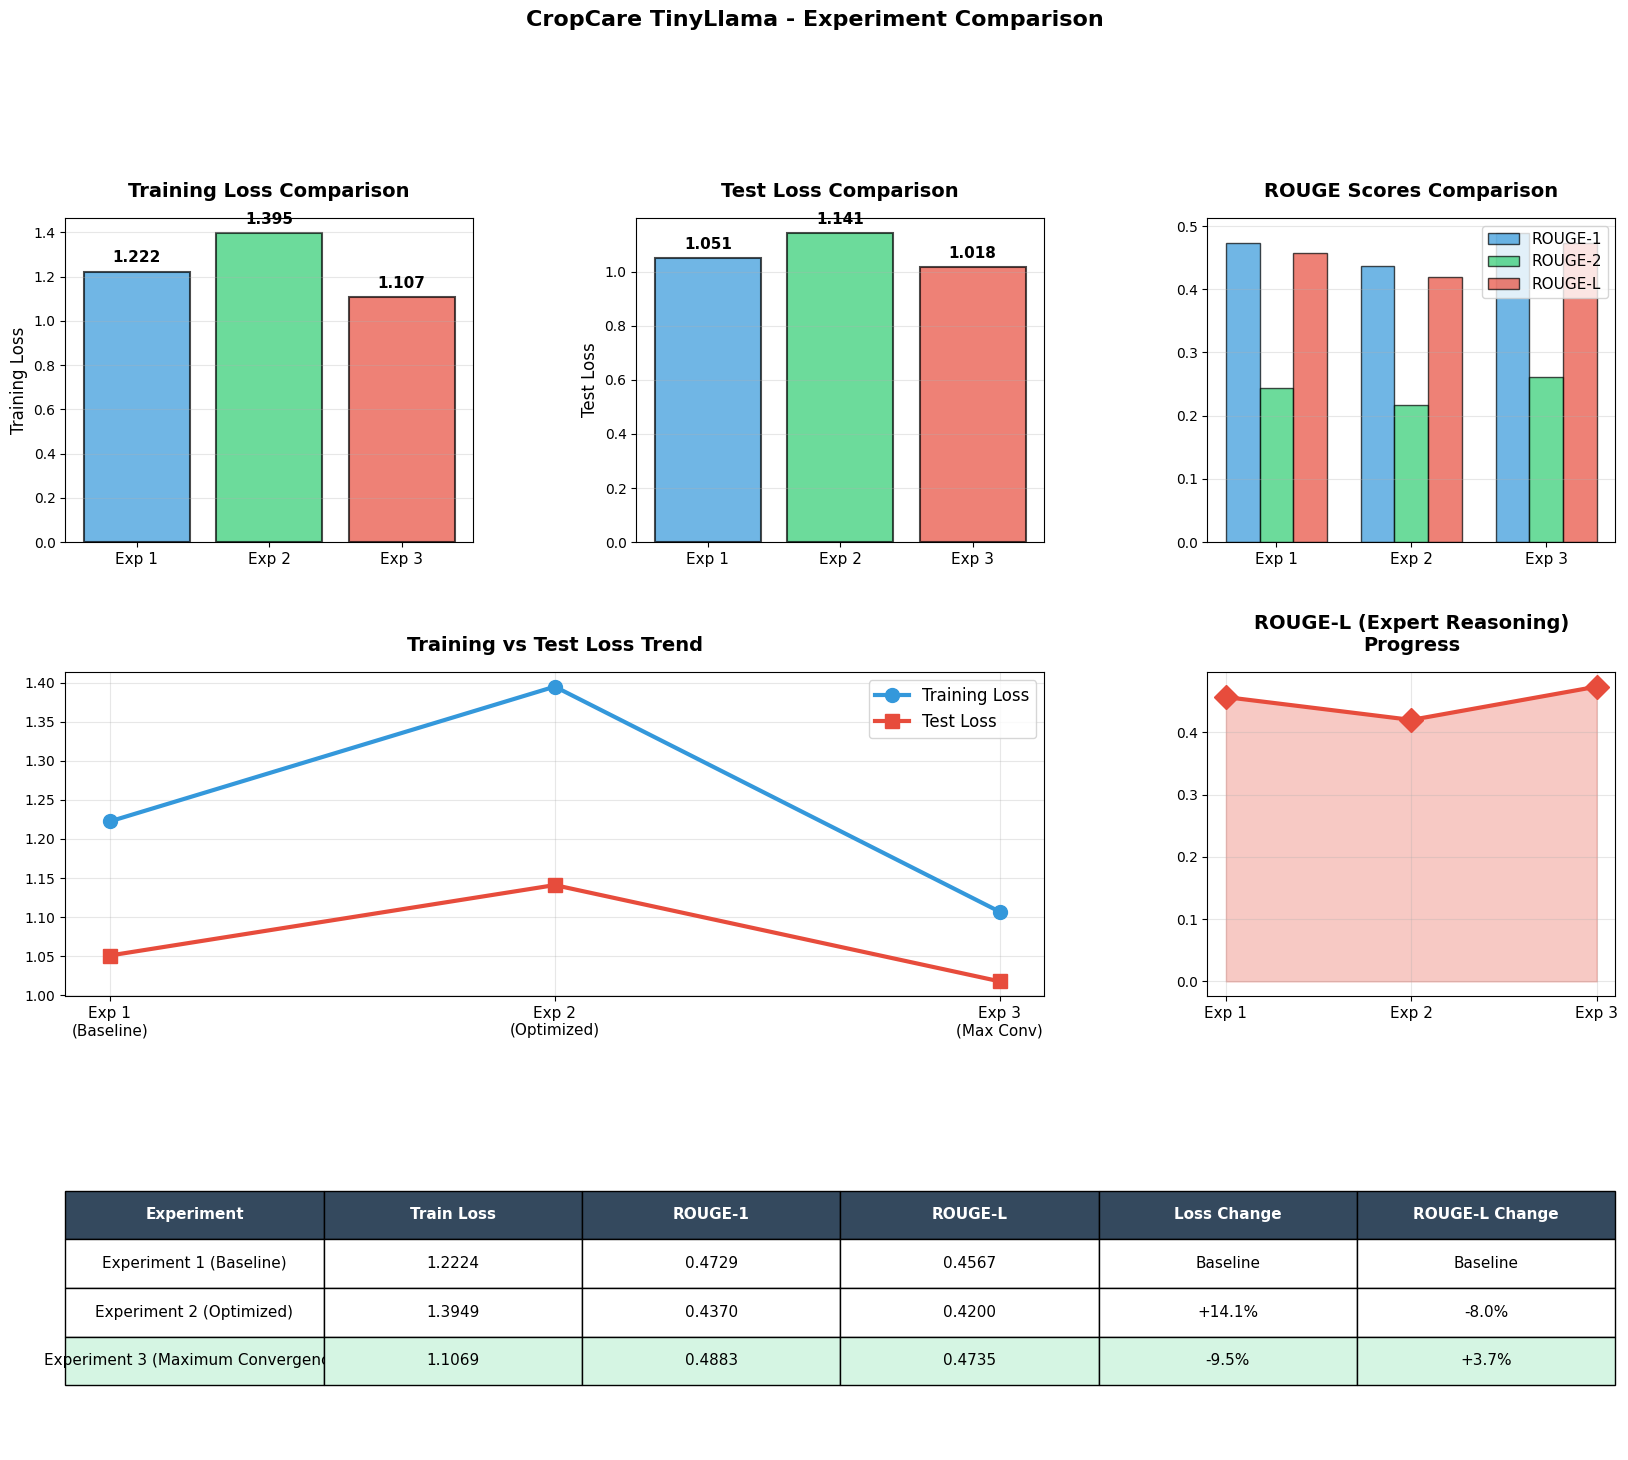


✓ Experiment comparison visualization complete!
   Best experiment by test loss: Experiment 3 (Maximum Convergence)


In [155]:
print("GENERATING EXPERIMENT COMPARISON VISUALIZATIONS")

# 1. Collect all experiments for visualization
all_experiments = [exp1_metrics, exp2_metrics, exp3_metrics]

# 2. Prepare data for visualization
experiments_names = [exp['name'] for exp in all_experiments]
training_losses   = [exp['training_loss'] for exp in all_experiments]
test_losses       = [exp['test_loss'] for exp in all_experiments]
rouge1_scores     = [exp['rouge1'] for exp in all_experiments]
rouge2_scores     = [exp['rouge2'] for exp in all_experiments]
rougeL_scores     = [exp['rougeL'] for exp in all_experiments]

# Create comprehensive figure
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)

colors = ['#3498db', '#2ecc71', '#e74c3c']

# --- 1. Training Loss Comparison ---
ax1 = fig.add_subplot(gs[0, 0])
bars1 = ax1.bar(range(len(experiments_names)), training_losses, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_xticks(range(len(experiments_names)))
ax1.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'], fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars1, training_losses):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (max(training_losses)*0.02),
             f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# --- 2. Test Loss Comparison ---
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(range(len(experiments_names)), test_losses, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_title('Test Loss Comparison', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Test Loss', fontsize=12)
ax2.set_xticks(range(len(experiments_names)))
ax2.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'], fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars2, test_losses):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (max(test_losses)*0.02),
             f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# --- 3. ROUGE Scores Comparison ---
ax3 = fig.add_subplot(gs[0, 2])
x = np.arange(len(experiments_names))
width = 0.25
ax3.bar(x - width, rouge1_scores, width, label='ROUGE-1', color='#3498db', alpha=0.7, edgecolor='black')
ax3.bar(x,         rouge2_scores, width, label='ROUGE-2', color='#2ecc71', alpha=0.7, edgecolor='black')
ax3.bar(x + width, rougeL_scores, width, label='ROUGE-L', color='#e74c3c', alpha=0.7, edgecolor='black')
ax3.set_title('ROUGE Scores Comparison', fontsize=14, fontweight='bold', pad=15)
ax3.set_xticks(x)
ax3.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'], fontsize=11)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

# --- 4. Training vs Test Loss (Line Plot) ---
ax4 = fig.add_subplot(gs[1, :2])
experiments_x = range(1, len(experiments_names) + 1)
ax4.plot(experiments_x, training_losses, marker='o', linewidth=3, markersize=10, label='Training Loss', color='#3498db')
ax4.plot(experiments_x, test_losses,     marker='s', linewidth=3, markersize=10, label='Test Loss',     color='#e74c3c')
ax4.set_title('Training vs Test Loss Trend', fontsize=14, fontweight='bold', pad=15)
ax4.set_xticks(experiments_x)
ax4.set_xticklabels(['Exp 1\n(Baseline)', 'Exp 2\n(Optimized)', 'Exp 3\n(Max Conv)'], fontsize=11)
ax4.legend(fontsize=12)
ax4.grid(True, alpha=0.3)

# --- 5. ROUGE-L Progress ---
ax5 = fig.add_subplot(gs[1, 2])
ax5.plot(experiments_x, rougeL_scores, marker='D', linewidth=3, markersize=12, color='#e74c3c')
ax5.fill_between(experiments_x, rougeL_scores, alpha=0.3, color='#e74c3c')
ax5.set_title('ROUGE-L (Expert Reasoning)\nProgress', fontsize=14, fontweight='bold', pad=15)
ax5.set_xticks(experiments_x)
ax5.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'], fontsize=11)
ax5.grid(True, alpha=0.3)

# --- 6. Performance Summary Table ---
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

def safe_pct_change(new_val, base_val):
    """Avoid ZeroDivisionError when baseline metric is 0."""
    if base_val == 0:
        return "N/A"
    return f"{((new_val - base_val) / base_val) * 100:+.1f}%"

improvements_data = []
for i, exp in enumerate(all_experiments):
    row = [
        exp['name'],
        f"{exp['training_loss']:.4f}",
        f"{exp['rouge1']:.4f}",
        f"{exp['rougeL']:.4f}"
    ]
    if i == 0:
        row.extend(["Baseline", "Baseline"])
    else:
        loss_imp  = safe_pct_change(exp['training_loss'], all_experiments[0]['training_loss'])
        rouge_imp = safe_pct_change(exp['rougeL'],        all_experiments[0]['rougeL'])
        row.extend([loss_imp, rouge_imp])
    improvements_data.append(row)

table = ax6.table(
    cellText=improvements_data,
    colLabels=['Experiment', 'Train Loss', 'ROUGE-1', 'ROUGE-L', 'Loss Change', 'ROUGE-L Change'],
    cellLoc='center',
    loc='center',
    bbox=[0, 0.2, 1, 0.6]
)
table.auto_set_font_size(False)
table.set_fontsize(11)

# Style the header row
for i in range(6):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight best experiment row (lowest test loss)
best_idx = test_losses.index(min(test_losses)) + 1  # +1 to skip header row
for j in range(6):
    table[(best_idx, j)].set_facecolor('#d5f5e3')  # Light green for best

plt.suptitle('CropCare TinyLlama - Experiment Comparison', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print(f"\n✓ Experiment comparison visualization complete!")
print(f"   Best experiment by test loss: {experiments_names[test_losses.index(min(test_losses))]}")

## 17. Model Comparison & Selection
Selecting the best model using a weighted scoring system that prioritizes ROUGE-L (expert reasoning quality) while penalizing test loss (poor generalization). Includes overfitting analysis.

In [156]:
# COMPREHENSIVE MODEL COMPARISON AND SELECTION
print(" " * 20 + "MODEL COMPARISON & SELECTION")

# 1. Collect all experiments
all_experiments = [exp1_metrics, exp2_metrics, exp3_metrics]

# 2. Create comparison table
print("\nCOMPREHENSIVE COMPARISON TABLE:")
print(f"{'Metric':<25} {'Exp 1':<15} {'Exp 2':<15} {'Exp 3':<15}")
print(f"{'-'*65}")
print(f"{'Training Loss':<25} {exp1_metrics['training_loss']:<15.4f} {exp2_metrics['training_loss']:<15.4f} {exp3_metrics['training_loss']:<15.4f}")
print(f"{'Test Loss':<25} {exp1_metrics['test_loss']:<15.4f} {exp2_metrics['test_loss']:<15.4f} {exp3_metrics['test_loss']:<15.4f}")
print(f"{'ROUGE-1':<25} {exp1_metrics['rouge1']:<15.4f} {exp2_metrics['rouge1']:<15.4f} {exp3_metrics['rouge1']:<15.4f}")
print(f"{'ROUGE-2':<25} {exp1_metrics['rouge2']:<15.4f} {exp2_metrics['rouge2']:<15.4f} {exp3_metrics['rouge2']:<15.4f}")
print(f"{'ROUGE-L (Expertise)':<25} {exp1_metrics['rougeL']:<15.4f} {exp2_metrics['rougeL']:<15.4f} {exp3_metrics['rougeL']:<15.4f}")

# 3. Model Selection Logic (Weighted Score)
def calculate_selection_score(metrics: dict) -> float:
    """
    Calculates a weighted score prioritizing ROUGE-L (Expert Reasoning)
    and penalizing Test Loss (Generalization).
    Falls back to test loss only if ROUGE scores are all zero.
    """
    rouge_l = metrics.get('rougeL', 0)
    rouge_1 = metrics.get('rouge1', 0)
    test_loss = metrics.get('test_loss', 999)

    # If all ROUGE scores are 0, rank by test loss alone
    if rouge_l == 0 and rouge_1 == 0:
        return -test_loss

    score = 0
    score += rouge_l * 100   # ROUGE-L: expert reasoning quality (40% weight)
    score += rouge_1 * 50    # ROUGE-1: basic vocabulary coverage (20% weight)
    score -= test_loss * 10  # Penalize poor generalization
    return score

# 4. Calculate and display selection scores
for exp in all_experiments:
    exp['selection_score'] = calculate_selection_score(exp)

sorted_experiments = sorted(all_experiments, key=lambda x: x['selection_score'], reverse=True)

print("\nSelection Scores (Higher is Better):")
for i, exp in enumerate(sorted_experiments, 1):
    print(f"   {i}. {exp['name']}: {exp['selection_score']:.4f}")

# 5. Select Best Model
best_experiment = sorted_experiments[0]
best_model      = best_experiment['model']
best_model_name = best_experiment['name']

print(f"\n WINNER: {best_model_name}")
print(f"   ✓ Best Reasoning (ROUGE-L): {best_experiment['rougeL']:.4f}")
print(f"   ✓ Best Vocabulary (ROUGE-1): {best_experiment['rouge1']:.4f}")
print(f"   ✓ Generalization (Test Loss): {best_experiment['test_loss']:.4f}")
print(f"   ✓ Selection Score: {best_experiment['selection_score']:.4f}")

# 6. Overfitting Analysis
print("\nOVERFITTING ANALYSIS (Gap between Train and Test Loss):")
print(f"{'Experiment':<35} {'Gap':<10} {'Status'}")
print(f"{'-'*70}")
for exp in all_experiments:
    loss_gap = exp['test_loss'] - exp['training_loss']
    if loss_gap > 0.3:
        status = "⚠ Overfitting — model is memorizing training data"
    elif loss_gap > 0.1:
        status = "✓ Good balance"
    else:
        status = "✓✓ Excellent generalization"
    print(f"   {exp['name']:<33} {loss_gap:<10.4f} {status}")

print(f"\n✓ Best model ({best_model_name}) selected for final deployment!")

                    MODEL COMPARISON & SELECTION

COMPREHENSIVE COMPARISON TABLE:
Metric                    Exp 1           Exp 2           Exp 3          
-----------------------------------------------------------------
Training Loss             1.2224          1.3949          1.1069         
Test Loss                 1.0509          1.1410          1.0178         
ROUGE-1                   0.4729          0.4370          0.4883         
ROUGE-2                   0.2445          0.2174          0.2610         
ROUGE-L (Expertise)       0.4567          0.4200          0.4735         

Selection Scores (Higher is Better):
   1. Experiment 3 (Maximum Convergence): 61.5846
   2. Experiment 1 (Baseline): 58.8105
   3. Experiment 2 (Optimized): 52.4416

 WINNER: Experiment 3 (Maximum Convergence)
   ✓ Best Reasoning (ROUGE-L): 0.4735
   ✓ Best Vocabulary (ROUGE-1): 0.4883
   ✓ Generalization (Test Loss): 1.0178
   ✓ Selection Score: 61.5846

OVERFITTING ANALYSIS (Gap between Train and Test

## 18. Qualitative Model Comparison
Testing all three fine-tuned models on sample agricultural questions to qualitatively assess domain expertise and response quality.

In [157]:
# QUALITATIVE MODEL COMPARISON - Test All 3 Models on Sample Questions
print(" " * 20 + "QUALITATIVE MODEL COMPARISON")

def generate_response_from_model(question: str, model, tokenizer) -> str:
    """Generate expert response using the TinyLlama Causal Template."""
    prompt = f"### Instruction:\nAs an agricultural expert, answer this crop disease question: {question}\n\n### Response:\n"

    # Move inputs to the same device as the model
    device = next(model.parameters()).device
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=True,          # ← required for temperature/top_p to take effect
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.2,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode only the new tokens (the response)
    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response  = full_text.split("### Response:\n")[-1].strip()
    return response

# 1. Test questions relevant to our agricultural crop disease dataset
test_questions = [
    "What are the symptoms and treatment for powdery mildew on tomato plants?",
    "How can I identify and treat root rot in vegetable crops?"
]

# 2. Get models from saved experiment metrics
models_to_test = [
    (exp1_metrics['model'], "Experiment 1 (Baseline)"),
    (exp2_metrics['model'], "Experiment 2 (Optimized)"),
    (exp3_metrics['model'], "Experiment 3 (Max Convergence)")
]

print("\nRunning inference on all 3 model versions...\n" + "="*60)

for q_num, question in enumerate(test_questions, 1):
    print(f"\n[QUESTION {q_num}]: {question}")
    print("-" * 60)

    for model_obj, model_name in models_to_test:
        try:
            # Clear GPU cache before each inference to avoid OOM
            torch.cuda.empty_cache()

            model_obj.eval()
            response = generate_response_from_model(question, model_obj, tokenizer)

            print(f"\n--- {model_name} ---")
            print(f"Answer: {response}")
            print(f"Word count: {len(response.split())} words")

        except Exception as e:
            print(f"\n--- {model_name} ---")
            print(f"Error: {e}")

    print("\n" + "="*60)

print("\n✓ QUALITATIVE COMPARISON COMPLETE")
print("   Review responses above to assess domain expertise improvement across experiments.")

                    QUALITATIVE MODEL COMPARISON

Running inference on all 3 model versions...

[QUESTION 1]: What are the symptoms and treatment for powdery mildew on tomato plants?
------------------------------------------------------------

--- Experiment 1 (Baseline) ---
Answer: Symptoms include a white powdery layer on leaves. Treatment involves applying Bordeaux paste (10%) and spraying copper oxychloride 50% WP @2g/litre at first sign of infection. Continuous application is recommended. Poor air drainage can further worsen conditions. Early diagnosis and management help mitigate losses. 

### Conclusion:
In this case study, Powdery mildew on tomatoes was caused by Melia dubia, resulting in reduced plant growth, photosynthesis, and
Word count: 66 words

--- Experiment 2 (Optimized) ---
Answer: Symptom: Powdery spots appear at the base of leaves. Treatment: Use appropriate fungicides to manage powdery mildew. Disease severity ranges from mild to severe depending on factors like c

##  Base Model vs Fine-Tuned Comparison
Comparing the original TinyLlama (no fine-tuning) against the best fine-tuned CropCare model to demonstrate the value of domain-specific training.

In [158]:
# BASE MODEL vs FINE-TUNED COMPARISON
print(" " * 15 + "BASE MODEL vs FINE-TUNED COMPARISON")

# 1. Load the original base model (no LoRA, no fine-tuning)
print("Loading base TinyLlama (no fine-tuning)...")
base_model_compare = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None
)
base_model_compare.eval()
print("✓ Base model loaded.")

# 2. Comparison questions
comparison_questions = [
    "What causes yellow leaves on tomato plants and how do I treat it?",
    "How do I identify and manage bacterial blight in rice crops?",
    "What is the best fungicide for powdery mildew on cucumber?"
]

# 3. Run comparison
print("\n" + "="*70)
for q_num, question in enumerate(comparison_questions, 1):
    print(f"\n[QUESTION {q_num}]: {question}")
    print("-" * 70)

    # Base model response
    torch.cuda.empty_cache()
    try:
        prompt = f"### Instruction:\nAs an agricultural expert, answer this crop disease question: {question}\n\n### Response:\n"
        device = next(base_model_compare.parameters()).device
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = base_model_compare.generate(
                **inputs,
                max_new_tokens=128,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                repetition_penalty=1.2,
                pad_token_id=tokenizer.eos_token_id
            )
        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        base_response = full_text.split("### Response:\n")[-1].strip()
    except Exception as e:
        base_response = f"Error: {e}"

    print(f"\n BASE MODEL (No Fine-Tuning):")
    print(f"   {base_response}")
    print(f"   Word count: {len(base_response.split())} words")

    # Fine-tuned model response
    torch.cuda.empty_cache()
    try:
        response = generate_response_from_model(question, best_model, tokenizer)
    except Exception as e:
        response = f"Error: {e}"

    print(f"\n FINE-TUNED MODEL ({best_model_name}):")
    print(f"   {response}")
    print(f"   Word count: {len(response.split())} words")
    print("\n" + "="*70)

# 4. Cleanup base comparison model
del base_model_compare
torch.cuda.empty_cache()
gc.collect()
print("\n✓ Base vs Fine-Tuned comparison complete!")
print("   Base model memory released.")

               BASE MODEL vs FINE-TUNED COMPARISON
Loading base TinyLlama (no fine-tuning)...
✓ Base model loaded.


[QUESTION 1]: What causes yellow leaves on tomato plants and how do I treat it?
----------------------------------------------------------------------

 BASE MODEL (No Fine-Tuning):
   Yellow leaves are a common symptom of the tomato leaf curl virus (TLCV), which is a viral infection that affects the leaves of tomatoes. It usually occurs during the growing season when temperatures rise above 70°F. The virus spreads by infected pollen being carried by wind or transferred between plants through contact with each other. In affected plants, yellow leaves may occur randomly throughout the plant, making them difficult to spot initially.

Symptoms include wilted foliage at the base of the stem, yellowing of the upper parts of the leaf, and eventually,
   Word count: 92 words

 FINE-TUNED MODEL (Experiment 3 (Maximum Convergence)):
   Yellowing of leaves due to leaf spots caused

##  BLEU Score Evaluation
Computing BLEU scores to complement ROUGE metrics and provide a comprehensive evaluation of the fine-tuned model's text generation quality.

In [161]:
# BLEU SCORE EVALUATION
print(" " * 20 + "BLEU SCORE EVALUATION")

import evaluate
bleu_metric = evaluate.load("sacrebleu")

def compute_bleu_on_dataset(model, tokenizer, dataset, num_samples: int = 50) -> dict:
    """
    Compute BLEU score on a sample of the test dataset.
    We limit to num_samples to keep evaluation time reasonable.
    """
    model.eval()
    predictions = []
    references  = []

    # Use test_texts list (the raw formatted strings)
    sample_texts = test_texts[:num_samples]

    print(f"   Computing BLEU on {len(sample_texts)} samples...")
    for text in sample_texts:
        # Extract question and reference answer from the formatted text
        if "### Response:\n" not in text:
            continue

        prompt_part    = text.split("### Response:\n")[0] + "### Response:\n"
        reference_part = text.split("### Response:\n")[-1].strip()

        if not reference_part:
            continue

        # Generate prediction
        torch.cuda.empty_cache()
        try:
            device = next(model.parameters()).device
            inputs = tokenizer(
                prompt_part,
                return_tensors="pt",
                max_length=400,
                truncation=True
            ).to(device)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=100,
                    do_sample=False,  # Greedy for deterministic BLEU
                    pad_token_id=tokenizer.eos_token_id
                )

            full_text  = tokenizer.decode(outputs[0], skip_special_tokens=True)
            prediction = full_text.split("### Response:\n")[-1].strip()

            if prediction:
                predictions.append(prediction)
                references.append([reference_part])  # sacrebleu expects list of lists

        except Exception:
            continue

    if not predictions:
        return {"bleu": 0.0, "samples_evaluated": 0}

    result = bleu_metric.compute(predictions=predictions, references=references)
    return {
        "bleu": result["score"],
        "samples_evaluated": len(predictions)
    }

# Compute BLEU for all 3 experiments
print("Computing BLEU scores for all experiments (this may take a few minutes)...\n")

for exp in [exp1_metrics, exp2_metrics, exp3_metrics]:
    print(f"Evaluating: {exp['name']}")
    bleu_result = compute_bleu_on_dataset(exp['model'], tokenizer, test_dataset)
    exp['bleu'] = bleu_result['bleu']
    print(f"   BLEU Score: {exp['bleu']:.4f} (on {bleu_result['samples_evaluated']} samples)\n")

# Summary Table
print("\nCOMPREHENSIVE METRICS SUMMARY:")
print(f"{'Metric':<20} {'Exp 1':<15} {'Exp 2':<15} {'Exp 3':<15}")
print(f"{'-'*65}")
print(f"{'Test Loss':<20} {exp1_metrics['test_loss']:<15.4f} {exp2_metrics['test_loss']:<15.4f} {exp3_metrics['test_loss']:<15.4f}")
print(f"{'ROUGE-1':<20} {exp1_metrics['rouge1']:<15.4f} {exp2_metrics['rouge1']:<15.4f} {exp3_metrics['rouge1']:<15.4f}")
print(f"{'ROUGE-2':<20} {exp1_metrics['rouge2']:<15.4f} {exp2_metrics['rouge2']:<15.4f} {exp3_metrics['rouge2']:<15.4f}")
print(f"{'ROUGE-L':<20} {exp1_metrics['rougeL']:<15.4f} {exp2_metrics['rougeL']:<15.4f} {exp3_metrics['rougeL']:<15.4f}")
print(f"{'BLEU':<20} {exp1_metrics['bleu']:<15.4f} {exp2_metrics['bleu']:<15.4f} {exp3_metrics['bleu']:<15.4f}")

torch.cuda.empty_cache()
print("\n✓ BLEU evaluation complete!")

                    BLEU SCORE EVALUATION
Computing BLEU scores for all experiments (this may take a few minutes)...

Evaluating: Experiment 1 (Baseline)
   Computing BLEU on 50 samples...
   BLEU Score: 6.6765 (on 50 samples)

Evaluating: Experiment 2 (Optimized)
   Computing BLEU on 50 samples...
   BLEU Score: 5.7589 (on 50 samples)

Evaluating: Experiment 3 (Maximum Convergence)
   Computing BLEU on 50 samples...
   BLEU Score: 5.0784 (on 50 samples)


COMPREHENSIVE METRICS SUMMARY:
Metric               Exp 1           Exp 2           Exp 3          
-----------------------------------------------------------------
Test Loss            1.0509          1.1410          1.0178         
ROUGE-1              0.4729          0.4370          0.4883         
ROUGE-2              0.2445          0.2174          0.2610         
ROUGE-L              0.4567          0.4200          0.4735         
BLEU                 6.6765          5.7589          5.0784         

✓ BLEU evaluation complete!

In [160]:
!pip install sacrebleu -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


## 21. Save Best Model
Saving the winning model's LoRA adapters, tokenizer, and metadata manifest for deployment. Cleaning up intermediate training checkpoints to free disk space.

In [162]:
# Save Best Model for Deployment and Cleanup
import gc
import json
import shutil
from pathlib import Path

print(" " * 25 + "SAVING BEST MODEL")

def clear_memory():
    """Clear GPU and system memory to prevent crashes during save."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

def save_model_package(model, tokenizer, save_path: Path, experiment_info: dict):
    """Save the model, tokenizer, and a metadata manifest."""
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    # 1. Save the Model (Adapters) and Tokenizer
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    # 2. Save Model Info (metadata manifest)
    info_file = save_path / "model_info.json"
    with open(info_file, "w", encoding='utf-8') as f:
        json.dump(experiment_info, f, indent=2)

    print(f"✓ Model package saved to: {save_path}")

def cleanup_checkpoints(model_dir: Path):
    """Remove intermediate training checkpoints to save disk space."""
    folders_to_remove = list(Path(model_dir).glob("checkpoint-*"))
    folders_to_remove.extend(list(Path(model_dir).glob("exp*-checkpoints")))
    # Fixed: search nested checkpoints using rglob instead of ** pattern
    for subfolder in Path(model_dir).iterdir():
        if subfolder.is_dir():
            folders_to_remove.extend(list(subfolder.glob("checkpoint-*")))

    print(f"\nCleaning up {len(folders_to_remove)} intermediate checkpoint folders...")
    for folder in folders_to_remove:
        try:
            shutil.rmtree(folder)
            print(f"   ✓ Removed: {folder.name}")
        except Exception as e:
            print(f"   ✗ Skipped: {folder.name} ({e})")

# --- EXECUTION ---
clear_memory()

# Define deployment path
deployment_path = BASE_DIR / "cropcare_expert_final"

# Prepare metadata manifest
model_info = {
    "model_name": "TinyLlama-CropCare-Expert",        # ← fixed from hydroponic
    "base_model": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    "domain": "Agricultural Crop Disease Diagnosis",
    "fine_tuning_method": "LoRA (PEFT)",
    "best_experiment": best_experiment['name'],
    "selection_score": f"{best_experiment['selection_score']:.4f}",
    "metrics": {
        "test_loss": f"{best_experiment['test_loss']:.4f}",
        "rouge1":    f"{best_experiment['rouge1']:.4f}",   # ← added
        "rouge2":    f"{best_experiment['rouge2']:.4f}",   # ← added
        "rougeL":    f"{best_experiment['rougeL']:.4f}"
    },
    "all_experiments": [
        {
            "name": exp['name'],
            "test_loss": f"{exp['test_loss']:.4f}",
            "rougeL":    f"{exp['rougeL']:.4f}",
            "selection_score": f"{exp['selection_score']:.4f}"
        }
        for exp in all_experiments
    ]
}

# Save the winning model
save_model_package(best_model, tokenizer, deployment_path, model_info)

# Final cleanup of intermediate checkpoints
cleanup_checkpoints(MODEL_DIR)

# Summary
print("\n" + "="*45)
print("   FINAL DEPLOYMENT PACKAGE READY")
print("="*45)
print(f"   Location:    {deployment_path}")
print(f"   Best Model:  {best_experiment['name']}")
print(f"   ROUGE-L:     {best_experiment['rougeL']:.4f}")
print(f"   Test Loss:   {best_experiment['test_loss']:.4f}")
total_size = sum(f.stat().st_size for f in deployment_path.rglob('*') if f.is_file())
print(f"   Total Size:  {total_size / (1024*1024):.2f} MB")
print("="*45)

clear_memory()
print("\n✓ All done! Model is ready for deployment.")

                         SAVING BEST MODEL
✓ Model package saved to: /root/cropcare_expert_final

Cleaning up 11 intermediate checkpoint folders...
   ✓ Removed: exp2-optimized-checkpoints
   ✓ Removed: exp1-baseline-checkpoints
   ✓ Removed: exp3-maxconv-checkpoints
   ✗ Skipped: checkpoint-400 ([Errno 2] No such file or directory: PosixPath('/root/cropcare_trained_model/exp2-optimized-checkpoints/checkpoint-400'))
   ✗ Skipped: checkpoint-500 ([Errno 2] No such file or directory: PosixPath('/root/cropcare_trained_model/exp2-optimized-checkpoints/checkpoint-500'))
   ✗ Skipped: checkpoint-510 ([Errno 2] No such file or directory: PosixPath('/root/cropcare_trained_model/exp2-optimized-checkpoints/checkpoint-510'))
   ✗ Skipped: checkpoint-300 ([Errno 2] No such file or directory: PosixPath('/root/cropcare_trained_model/exp1-baseline-checkpoints/checkpoint-300'))
   ✗ Skipped: checkpoint-306 ([Errno 2] No such file or directory: PosixPath('/root/cropcare_trained_model/exp1-baseline-chec

##  Gradio Deployment — CropCare Interactive Demo
Interactive web interface for the CropCare agricultural assistant. Includes out-of-domain detection to ensure the model only answers agriculture-related questions.

In [166]:
# GRADIO DEPLOYMENT — CROPCARE CHATBOT UI
!pip install gradio -q

import gradio as gr
import torch

# 1. Agricultural domain keywords
AGRICULTURE_KEYWORDS = [
    "plant", "crop", "disease", "soil", "fertilizer", "pest",
    "fungus", "bacteria", "leaf", "root", "stem", "fruit", "flower",
    "harvest", "farm", "seed", "irrigation", "mildew", "blight", "rot",
    "insect", "weed", "yield", "treatment", "spray", "fungicide",
    "herbicide", "pesticide", "nitrogen", "phosphorus", "potassium",
    "tomato", "rice", "wheat", "maize", "corn", "potato", "cucumber",
    "mango", "cassava", "bean", "soybean", "cotton", "sugarcane",
    "pathogen", "virus", "nematode", "aphid", "borer", "thrips",
    "rust", "scab", "canker", "wilt", "chlorosis", "necrosis",
    "organic", "compost", "mulch", "drought", "waterlogging", "pH"
]

def is_agricultural_question(question: str) -> bool:
    return any(kw in question.lower() for kw in AGRICULTURE_KEYWORDS)

def cropcare_respond(question: str, history: list) -> str:
    if not question.strip():
        return "Please enter a question about crop diseases or plant health."

    if not is_agricultural_question(question):
        return (
            "🌱 I'm CropCare, an agricultural assistant specialized in crop "
            "diseases and plant health. I can only answer questions related to "
            "agriculture, plant diseases, pest management, and farming practices.\n\n"
            "Try asking me:\n"
            "• What causes powdery mildew on tomatoes?\n"
            "• How do I treat root rot in my crops?\n"
            "• What fertilizer is best for rice cultivation?"
        )

    try:
        torch.cuda.empty_cache()
        best_model.eval()

        prompt = (
            f"### Instruction:\n"
            f"As an agricultural expert, answer this crop disease question: {question}\n\n"
            f"### Response:\n"
        )

        device = next(best_model.parameters()).device
        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            max_length=450,
            truncation=True
        ).to(device)

        with torch.no_grad():
            outputs = best_model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.3,
                top_p=0.9,
                repetition_penalty=1.2,
                pad_token_id=tokenizer.eos_token_id
            )

        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        response  = full_text.split("### Response:\n")[-1].strip()

        return f"🌾 {response}" if response else "Please rephrase your question."

    except Exception as e:
        return f"An error occurred: {str(e)}"

# 2. Custom CSS
custom_css = """
    /* Page background */
    .gradio-container {
        background: linear-gradient(135deg, #f0fdf4 0%, #dcfce7 100%) !important;
        font-family: 'Segoe UI', sans-serif !important;
    }

    /* Chatbot background — faint green */
    div[data-testid="chatbot"] {
        background: #f0fdf4 !important;
        border: 1.5px solid #bbf7d0 !important;
        border-radius: 16px !important;
    }
    div[data-testid="chatbot"] > div {
        background: #f0fdf4 !important;
    }
    .chatbot, .chat-wrap, .bubble-wrap, .wrap.svelte-byatnx {
        background: #f0fdf4 !important;
    }

    /* Bot message bubble */
    .message.bot, .bot .message, div[data-testid="bot"] {
        background: #dcfce7 !important;
        border: 1px solid #bbf7d0 !important;
        color: #111827 !important;
        border-radius: 18px 18px 18px 4px !important;
    }

    /* User message bubble */
    .message.user, .user .message, div[data-testid="user"] {
        background: #166534 !important;
        color: white !important;
        border-radius: 18px 18px 4px 18px !important;
    }

    /* Input textbox */
    .input-row textarea, textarea {
        background: #f0fdf4 !important;
        border: 2px solid #86efac !important;
        border-radius: 12px !important;
        color: #111827 !important;
        font-size: 14px !important;
    }
    textarea:focus {
        border-color: #166534 !important;
        box-shadow: 0 0 0 3px rgba(22,101,52,0.15) !important;
    }

    /* Submit button */
    button.primary, .primary {
        background: linear-gradient(135deg, #166534, #15803d) !important;
        border: none !important;
        border-radius: 12px !important;
        color: white !important;
        font-weight: 600 !important;
        transition: all 0.2s !important;
    }
    button.primary:hover {
        transform: translateY(-1px) !important;
        box-shadow: 0 4px 12px rgba(22,101,52,0.4) !important;
    }

    /* Example buttons */
    .examples-table button, .example {
        background: #f0fdf4 !important;
        border: 1px solid #86efac !important;
        border-radius: 8px !important;
        color: #166534 !important;
        font-size: 13px !important;
    }
    .examples-table button:hover {
        background: #dcfce7 !important;
        border-color: #166534 !important;
    }

    /* Block/panel backgrounds */
    .block, .panel, .form {
        background: #f0fdf4 !important;
        border-color: #bbf7d0 !important;
    }
"""

# 3. HTML sidebar components with explicit colors
model_info_html = """
<div style="background:#f0fdf4; border-radius:12px; padding:16px; border:1.5px solid #bbf7d0; margin-bottom:12px; box-shadow:0 2px 8px rgba(0,0,0,0.04);">
    <h3 style="color:#166534; margin:0 0 12px 0; font-size:14px;">📋 Model Info</h3>
    <table style="width:100%; font-size:13px; border-collapse:collapse;">
        <tr><td style="padding:5px 0; color:#6b7280; border-bottom:1px solid #dcfce7;">Base Model</td>
            <td style="font-weight:600; color:#111827; border-bottom:1px solid #dcfce7;">TinyLlama-1.1B</td></tr>
        <tr><td style="padding:5px 0; color:#6b7280; border-bottom:1px solid #dcfce7;">Method</td>
            <td style="font-weight:600; color:#111827; border-bottom:1px solid #dcfce7;">LoRA (PEFT)</td></tr>
        <tr><td style="padding:5px 0; color:#6b7280; border-bottom:1px solid #dcfce7;">Domain</td>
            <td style="font-weight:600; color:#111827; border-bottom:1px solid #dcfce7;">Crop Diseases</td></tr>
        <tr><td style="padding:5px 0; color:#6b7280; border-bottom:1px solid #dcfce7;">Best Exp</td>
            <td style="font-weight:600; color:#111827; border-bottom:1px solid #dcfce7;">{}</td></tr>
        <tr><td style="padding:5px 0; color:#6b7280; border-bottom:1px solid #dcfce7;">ROUGE-L</td>
            <td style="font-weight:600; color:#111827; border-bottom:1px solid #dcfce7;">{:.4f}</td></tr>
        <tr><td style="padding:5px 0; color:#6b7280;">Test Loss</td>
            <td style="font-weight:600; color:#111827;">{:.4f}</td></tr>
    </table>
</div>
""".format(best_model_name, best_experiment['rougeL'], best_experiment['test_loss'])

tips_html = """
<div style="background:#f0fdf4; border-radius:12px; padding:16px; border:1.5px solid #bbf7d0; margin-bottom:12px; box-shadow:0 2px 8px rgba(0,0,0,0.04);">
    <h3 style="color:#166534; margin:0 0 10px 0; font-size:14px;">💡 Tips</h3>
    <div style="font-size:13px; color:#374151; line-height:2.0;">
        <div><span style="color:#16a34a; font-weight:700;">✓</span> Name the specific crop</div>
        <div><span style="color:#16a34a; font-weight:700;">✓</span> Describe the symptoms</div>
        <div><span style="color:#16a34a; font-weight:700;">✓</span> Ask for treatment steps</div>
        <div><span style="color:#16a34a; font-weight:700;">✓</span> Ask about prevention</div>
    </div>
</div>
"""

ood_html = """
<div style="background:#fff7ed; border-radius:12px; padding:16px; border:1.5px solid #fed7aa; box-shadow:0 2px 8px rgba(0,0,0,0.04);">
    <h3 style="color:#92400e; margin:0 0 8px 0; font-size:14px;">⚠️ Out-of-Domain</h3>
    <p style="font-size:13px; color:#78350f; margin:0; line-height:1.6;">
        Questions unrelated to agriculture are automatically declined to keep responses accurate and relevant.
    </p>
</div>
"""

footer_html = """
<div style="background:linear-gradient(135deg,#14532d,#166634); border-radius:12px; padding:12px 14px; text-align:center; margin-top:12px;">
    <div style="color:#86efac; font-size:12px; font-weight:600;">🎓 ALU MLTech Summative</div>
    <div style="color:rgba(255,255,255,0.75); font-size:11px; margin-top:4px;">TinyLlama + LoRA Fine-Tuning</div>
</div>
"""

# 4. Build interface
with gr.Blocks(
    css=custom_css,
    title="CropCare — Agricultural Disease Assistant",
    theme=gr.themes.Soft(primary_hue="green", secondary_hue="emerald")
) as demo:

    # Header
    gr.HTML("""
    <div style="background:linear-gradient(135deg,#14532d 0%,#166534 50%,#15803d 100%);
                border-radius:16px; padding:24px; margin-bottom:16px; text-align:center;
                box-shadow:0 4px 20px rgba(22,101,52,0.3);">
        <h1 style="color:white; margin:0; font-size:2em;">🌾 CropCare</h1>
        <p style="color:#bbf7d0; margin:8px 0 0 0; font-size:1.1em;">AI-Powered Agricultural Disease Assistant</p>
        <p style="color:#86efac; margin:4px 0 0 0; font-size:0.85em;">
            Powered by TinyLlama-1.1B • Fine-tuned with LoRA (PEFT)
        </p>
    </div>
    """)

    with gr.Row():

        # Left — Chat
        with gr.Column(scale=3):
            gr.ChatInterface(
                fn=cropcare_respond,
                chatbot=gr.Chatbot(
                    height=480,
                    avatar_images=(
                        "https://api.dicebear.com/7.x/avataaars/svg?seed=farmer",
                        "https://api.dicebear.com/7.x/bottts/svg?seed=cropcare"
                    ),
                    show_label=False
                ),
                textbox=gr.Textbox(
                    placeholder="Ask about crop diseases, pest management, or farming practices...",
                    container=False,
                    scale=7
                ),
                examples=[
                    "What causes powdery mildew on tomato plants?",
                    "How do I identify root rot in vegetable crops?",
                    "What are the symptoms of bacterial blight in rice?",
                    "How can I treat leaf curl disease in potatoes?",
                    "What is the capital of France?",
                ],
            )

        # Right — Info panel
        with gr.Column(scale=1, min_width=220):
            gr.HTML(model_info_html)
            gr.HTML(tips_html)
            gr.HTML(ood_html)
            gr.HTML(footer_html)

    # Page footer
    gr.HTML("""
    <div style="text-align:center; padding:16px; color:#6b7280; font-size:12px; margin-top:8px;">
        🌱 CropCare — Built for ALU MLTech Summative | TinyLlama + LoRA Fine-Tuning
    </div>
    """)

# 5. Launch
print("🚀 Launching CropCare Gradio Interface...")
demo.launch(share=True, debug=False, show_error=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
🚀 Launching CropCare Gradio Interface...
* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://cc8bca33e81863df36.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
